In [1]:
required_packages <- c("plgp", "lhs", "mvtnorm", "laGP", "hetGP")
install.packages(setdiff(required_packages, rownames(installed.packages())))

also installing the dependencies ‘maptree’, ‘tgp’, ‘DiceDesign’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### 7.1.1 A running example

In [2]:
matrix((c(1, 1)), nrow=1)

1,1


In [3]:
f <- function(X)
 {
  if(is.null(nrow(X))) X <- matrix(X, nrow=1)
  m <- 8.6928
  s <- 2.4269
  x1 <- 4*X[,1] - 2
  x2 <- 4*X[,2] - 2
  a <- 1 + (x1 + x2 + 1)^2 * 
    (19 - 14*x1 + 3*x1^2 - 14*x2 + 6*x1*x2 + 3*x2^2)
  b <- 30 + (2*x1 - 3*x2)^2 * 
    (18 - 32*x1 + 12*x1^2 + 48*x2 - 36*x1*x2 + 27*x2^2)
  f <- log(a*b)
  f <- (f - m)/s
  return(f)
 }

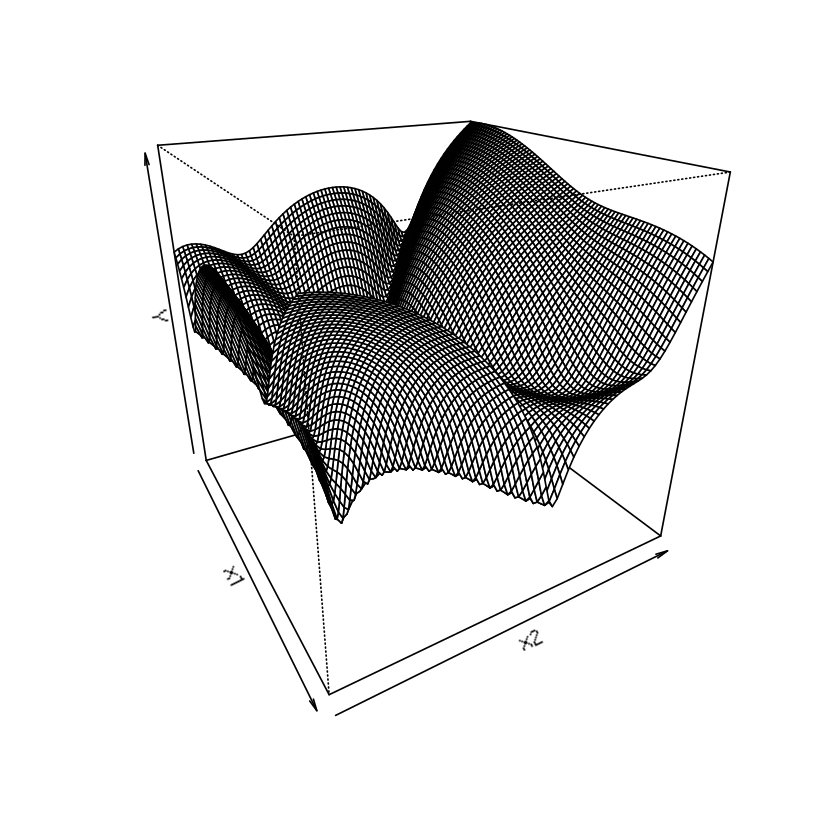

[1] -3.107947  2.117190

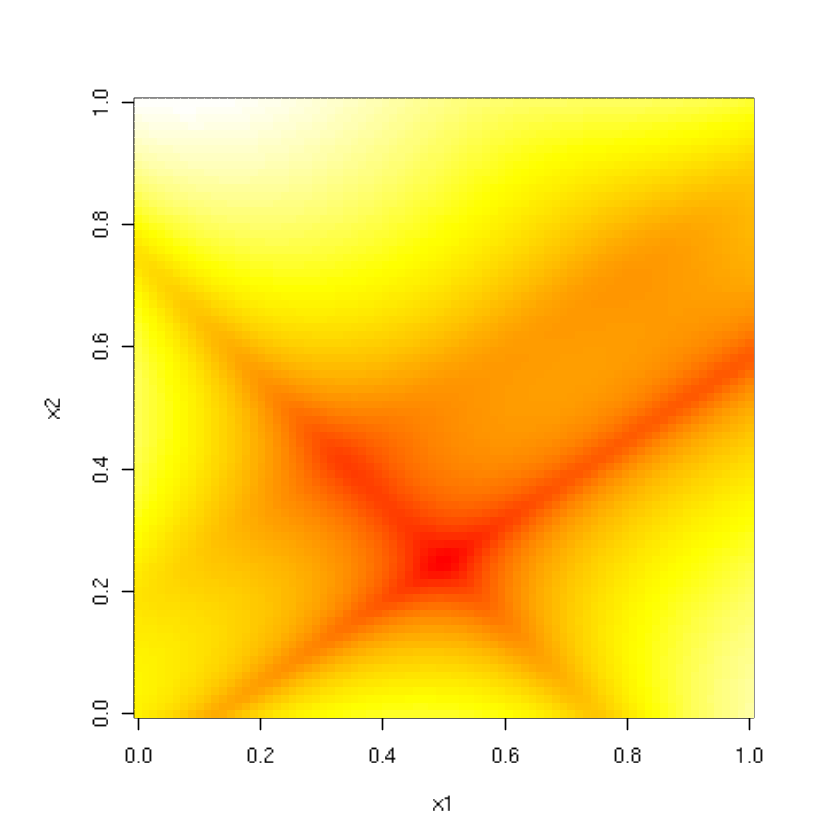

In [4]:
par(pty="s")
x1 <- x2 <- seq(0, 1, length=80)
y <- f(expand.grid(x1, x2))
Y <- matrix(y, ncol=length(x2))
persp(x=x1, y=x2, z=Y, theta=60, phi=25)
image(x1, x2, Y, col=heat.colors(128))
range(y)

In [5]:
set.seed(1111)
library(lhs)
ninit <- 12
X <- randomLHS(ninit, 2)
y <- f(X)
X
y

0.83854002,0.283798072
0.58621737,0.698796227
0.30324519,0.768032785
0.81718166,0.494269013
0.12232623,0.113261991
0.01399202,0.002180889
0.71205930,0.592789093
0.36652815,0.834861588
0.99425162,0.214497440
0.56258229,0.542654973
0.18634893,0.412867039


[1]  0.392092328  0.006234867  1.158070206 -1.322835880  0.267228615
 [6]  0.512894212 -0.703388452  1.328735350  1.214557745 -0.799506850
[11] -0.357715047  1.593225801

In [6]:
library(laGP)

In [7]:
da <- darg(list(mle=TRUE, max=0.5), randomLHS(1000, 2))
da

$mle
[1] TRUE

$max
[1] 0.5

$start
[1] 0.03823141

$min
[1] 1.85526e-06

$ab
[1] 1.50000 2.10893

In [8]:
gpi <- newGPsep(X, y, d=da$start, g=1e-6, dK=TRUE)
mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)

$d
[1] 0.39205847 0.05184895

$its
[1] 18

$msg
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

$conv
[1] 0

In [9]:
obj.mean <- function(x, gpi) 
  predGPsep(gpi, matrix(x, nrow=1), lite=TRUE)$mean

In [10]:
m <- which.min(y)
opt <- optim(X[m,], obj.mean, lower=0, upper=1, method="L-BFGS-B", gpi=gpi)
opt

$par
[1] 0.8321690 0.4688095

$value
[1] -1.362268

$counts
function gradient 
      11       11 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

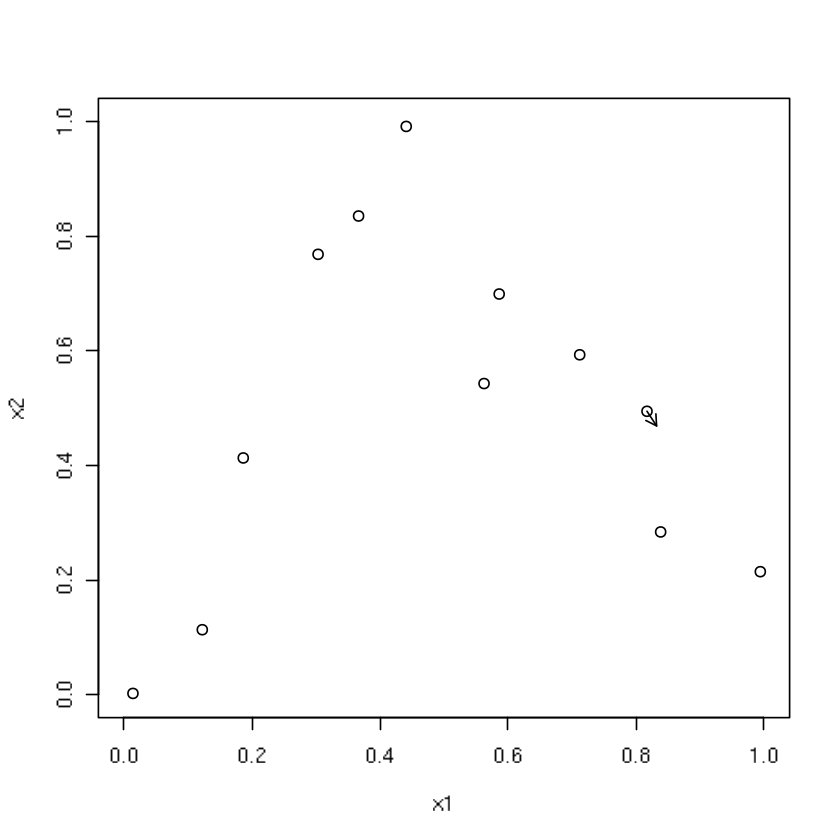

In [11]:
plot(X[1:ninit,], xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(X[m,1], X[m,2], opt$par[1], opt$par[2], length=0.1)

In [12]:
ynew <- f(opt$par)
updateGPsep(gpi, matrix(opt$par, nrow=1), ynew)
mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
X <- rbind(X, opt$par)
y <- c(y, ynew)

In [13]:
m <- which.min(y)
opt <- optim(X[m,], obj.mean, lower=0, upper=1, method="L-BFGS-B", gpi=gpi)
opt$par

[1] 0.8841329 0.4212346

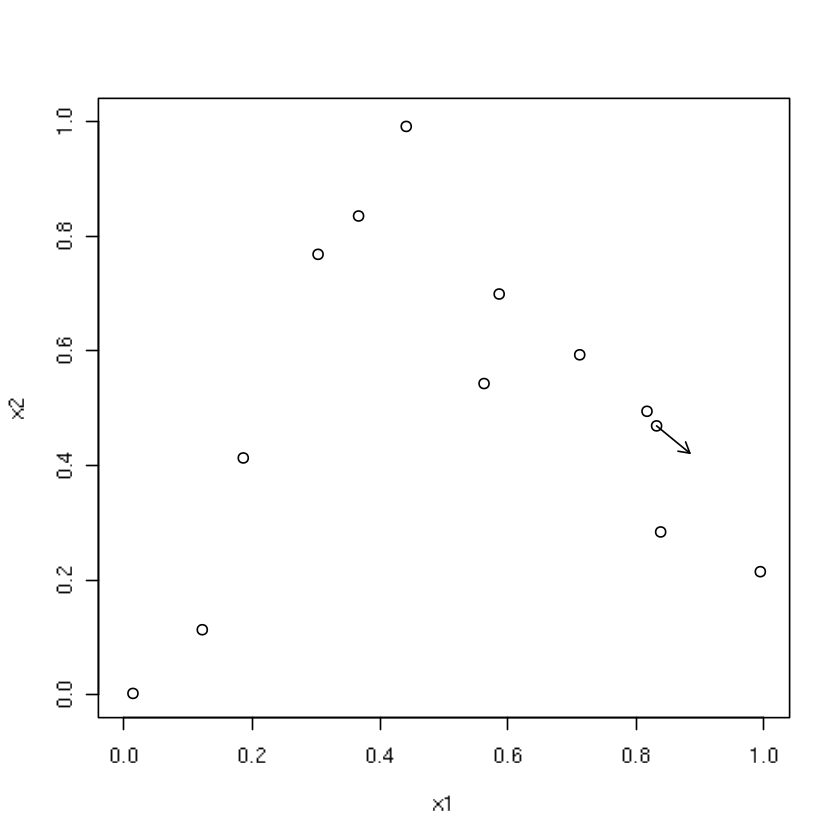

In [14]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(X[m,1], X[m,2], opt$par[1], opt$par[2], length=0.1)

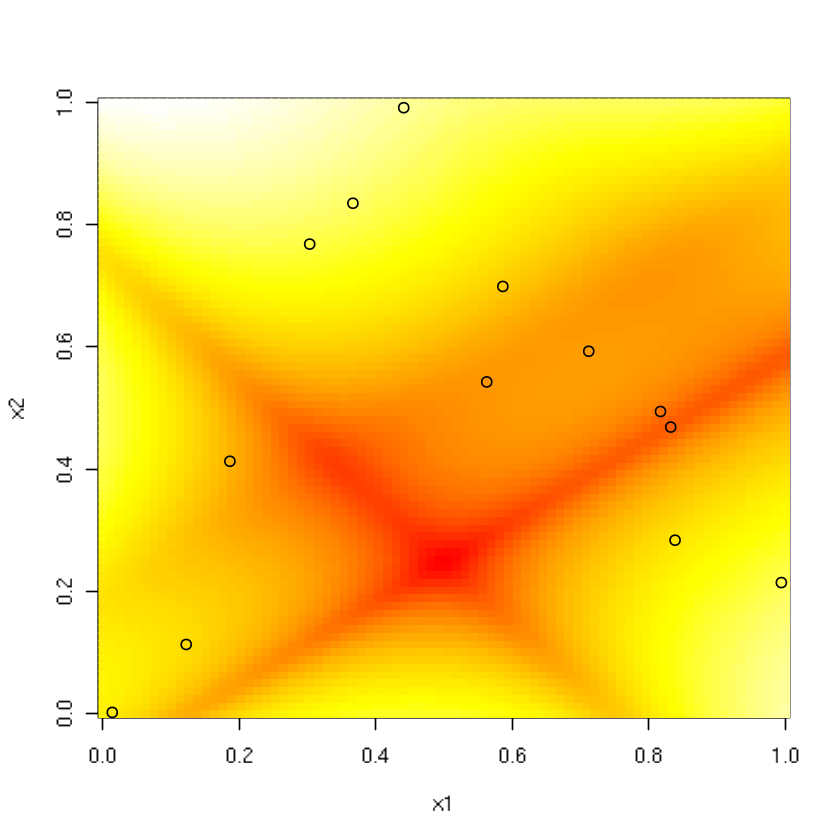

In [15]:
image(x1, x2, Y, col=heat.colors(128))
points(X[,1], X[,2])

In [16]:
ynew <- f(opt$par)
updateGPsep(gpi, matrix(opt$par, nrow=1), ynew)
mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
X <- rbind(X, opt$par)
y <- c(y, ynew)

In [17]:
while(1) {
  m <- which.min(y)
  opt <- optim(X[m,], obj.mean, lower=0, upper=1, 
    method="L-BFGS-B", gpi=gpi)
  ynew <- f(opt$par)
  if(abs(ynew - y[length(y)]) < 1e-4) break
  updateGPsep(gpi, matrix(opt$par, nrow=1), ynew)
  mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
  X <- rbind(X, opt$par)
  y <- c(y, ynew)
}
deleteGPsep(gpi)

In [18]:
X

0.83854002,0.283798072
0.58621737,0.698796227
0.30324519,0.768032785
0.81718166,0.494269013
0.12232623,0.113261991
0.01399202,0.002180889
0.71205930,0.592789093
0.36652815,0.834861588
0.99425162,0.214497440
0.56258229,0.542654973
0.18634893,0.412867039


In [19]:
y

[1]  0.392092328  0.006234867  1.158070206 -1.322835880  0.267228615
 [6]  0.512894212 -0.703388452  1.328735350  1.214557745 -0.799506850
[11] -0.357715047  1.593225801 -1.689218476 -0.429970663 -1.235181311
[16] -1.078590463 -1.686467408 -1.691811040 -1.690059099 -1.691762055
[21] -1.692391502 -1.692998095

In [20]:
bov <- function(y, end=length(y))
 {
  prog <- rep(min(y), end)
  prog[1:min(end, length(y))] <- y[1:min(end, length(y))]
  for(i in 2:end) 
    if(is.na(prog[i]) || prog[i] > prog[i-1]) prog[i] <- prog[i-1]
  return(prog)
 }

In [21]:
prog <- bov(y)

In [22]:
y

[1]  0.392092328  0.006234867  1.158070206 -1.322835880  0.267228615
 [6]  0.512894212 -0.703388452  1.328735350  1.214557745 -0.799506850
[11] -0.357715047  1.593225801 -1.689218476 -0.429970663 -1.235181311
[16] -1.078590463 -1.686467408 -1.691811040 -1.690059099 -1.691762055
[21] -1.692391502 -1.692998095

In [23]:
prog

[1]  0.392092328  0.006234867  0.006234867 -1.322835880 -1.322835880
 [6] -1.322835880 -1.322835880 -1.322835880 -1.322835880 -1.322835880
[11] -1.322835880 -1.322835880 -1.689218476 -1.689218476 -1.689218476
[16] -1.689218476 -1.689218476 -1.691811040 -1.691811040 -1.691811040
[21] -1.692391502 -1.692998095

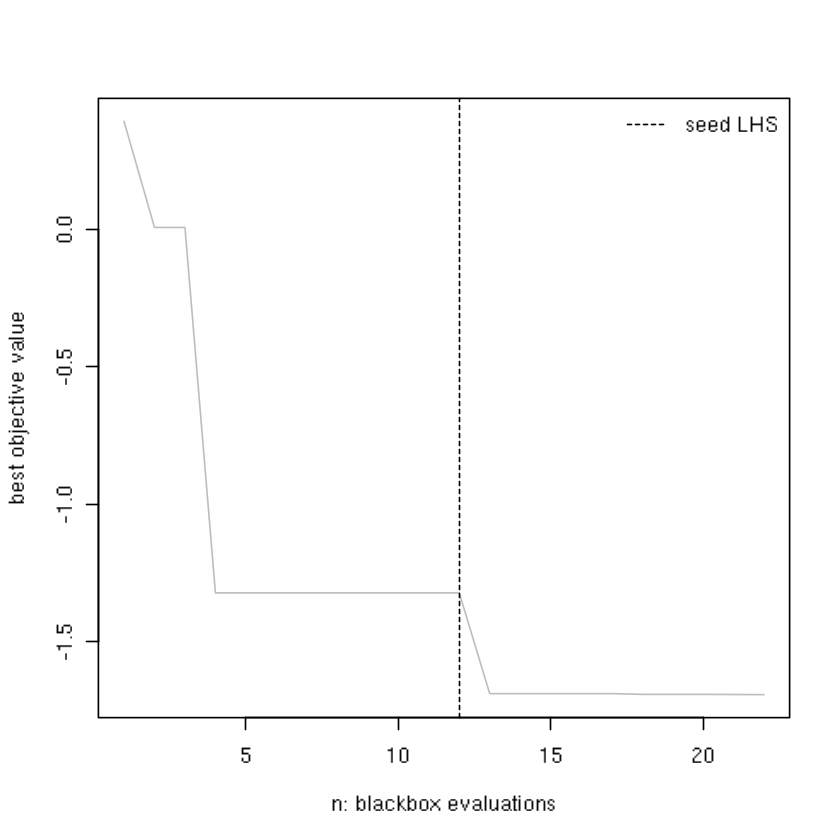

In [24]:
plot(prog, type="l", col="gray", xlab="n: blackbox evaluations", 
  ylab="best objective value")
abline(v=ninit, lty=2)
legend("topright", "seed LHS", lty=2, bty="n")

In [25]:
optim.surr <- function(f, m, ninit, end, tol=1e-4)
 {
  ## initialization
  X <- randomLHS(ninit, m)
  y <- f(X)
  da <- darg(list(mle=TRUE, max=0.5), randomLHS(1000, m))
  gpi <- newGPsep(X, y, d=da$start, g=1e-6, dK=TRUE)
  mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)

  ## optimization loop
  for(i in (ninit+1):end) {
    m <- which.min(y)
    opt <- optim(X[m,], obj.mean, lower=0, upper=1, 
      method="L-BFGS-B", gpi=gpi)
    ynew <- f(opt$par)
    if(abs(ynew - y[length(y)]) < tol) break
    updateGPsep(gpi, matrix(opt$par, nrow=1), ynew)
    mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
    X <- rbind(X, opt$par)
    y <- c(y, ynew)
  }

  ## clean up and return
  deleteGPsep(gpi)
  return(list(X=X, y=y))
 }

In [26]:
reps <- 100
end <- 100
prog <- matrix(NA, nrow=reps, ncol=end)
for(r in 1:reps) {
  os <- optim.surr(f, 2, ninit, end)
  prog[r,] <- bov(os$y, end)
}

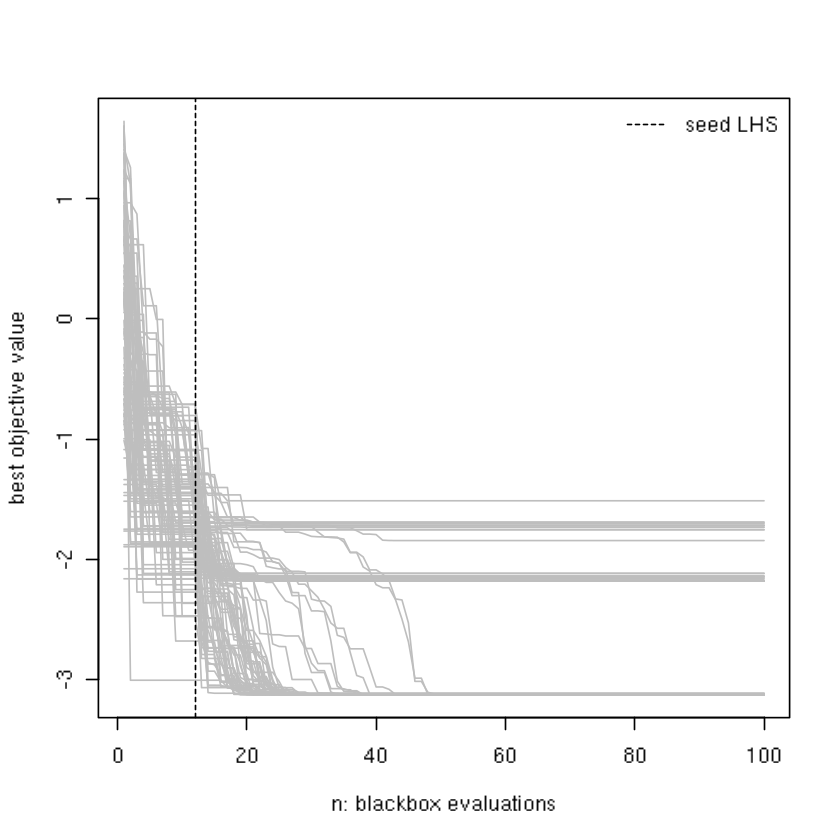

In [27]:
matplot(t(prog), type="l", col="gray", lty=1, 
  xlab="n: blackbox evaluations",  ylab="best objective value")
abline(v=ninit, lty=2)
legend("topright", "seed LHS", lty=2, bty="n")

### 7.1.2 A classical comparator

In [28]:
fprime <- function(x)
 {
  ynew <- f(x)
  y <<- c(y, ynew)
  return(ynew)
 }

In [29]:
prog.optim <- matrix(NA, nrow=reps, ncol=end)
for(r in 1:reps) {
  y <- c()
  os <- optim(runif(2), fprime, lower=0, upper=1, method="L-BFGS-B")
  prog.optim[r,] <- bov(y, end) 
}

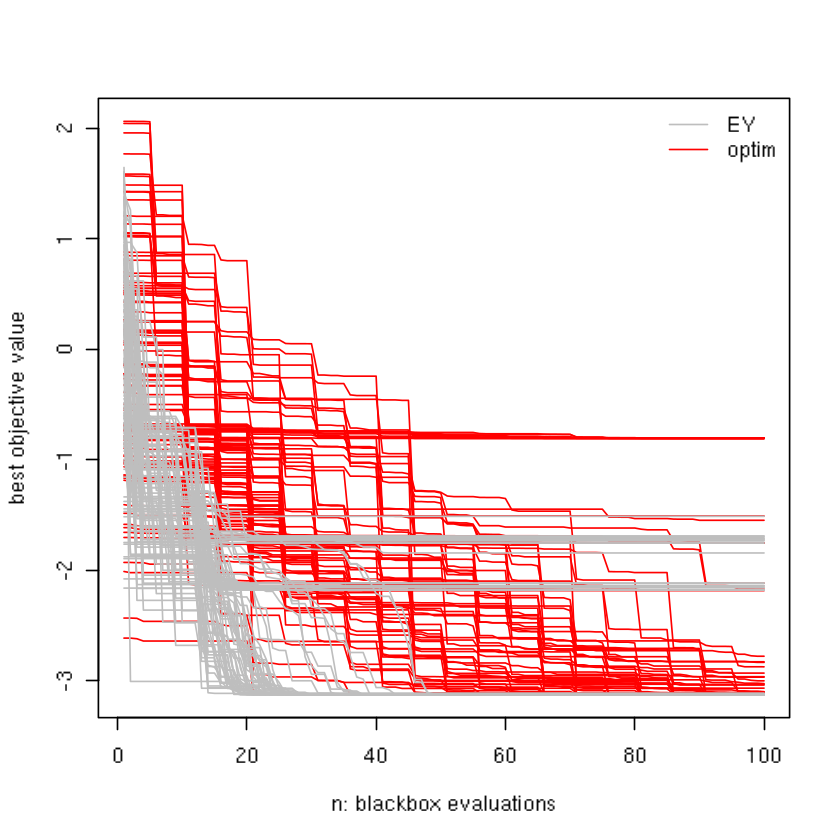

In [30]:
matplot(t(prog.optim), type="l", col="red", lty=1, 
  xlab="n: blackbox evaluations", ylab="best objective value")
matlines(t(prog), type="l", col="gray", lty=1)
legend("topright", c("EY", "optim"), col=c("gray", "red"), lty=1, bty="n")

## 7.2.1 Classic EI illustration

In [31]:
x <- c(1, 2, 3, 4, 12)
y <- c(0, -1.75, -2, -0.5, 5)

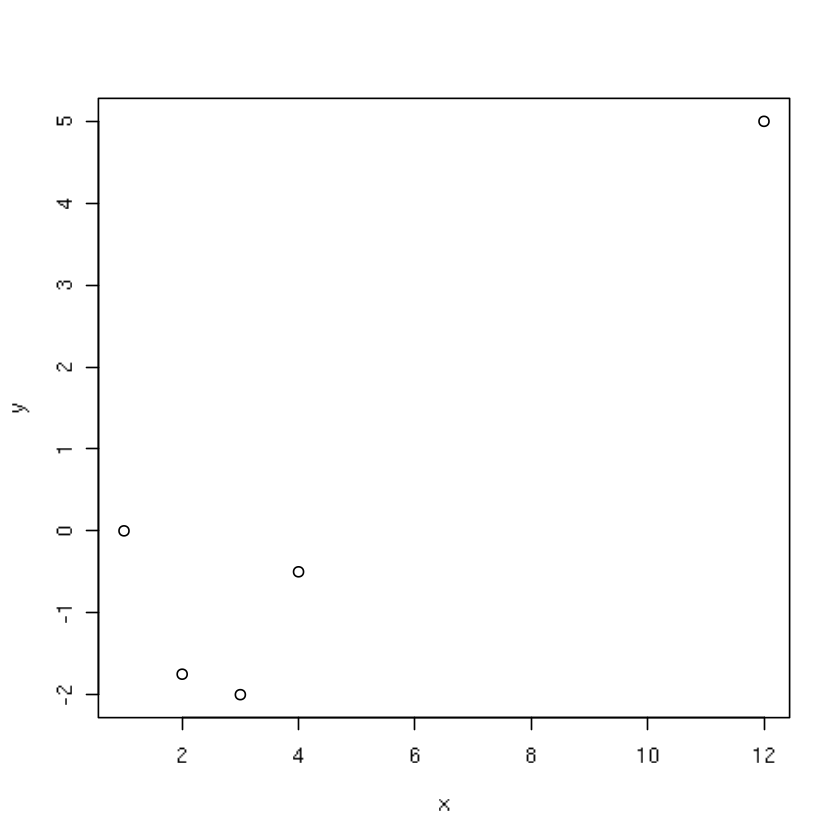

In [32]:
plot(x, y)

In [33]:
gpi <- newGP(matrix(x, ncol=1), y, d=10, g=1e-8)
xx <- seq(0, 13, length=1000)
p <- predGP(gpi, matrix(xx, ncol=1), lite=TRUE)

In [34]:
m <- which.min(y)
fmin <- y[m]
d <- fmin - p$mean
s <- sqrt(p$s2)
dn <- d/s
ei <- d*pnorm(dn) + s* dnorm(dn)

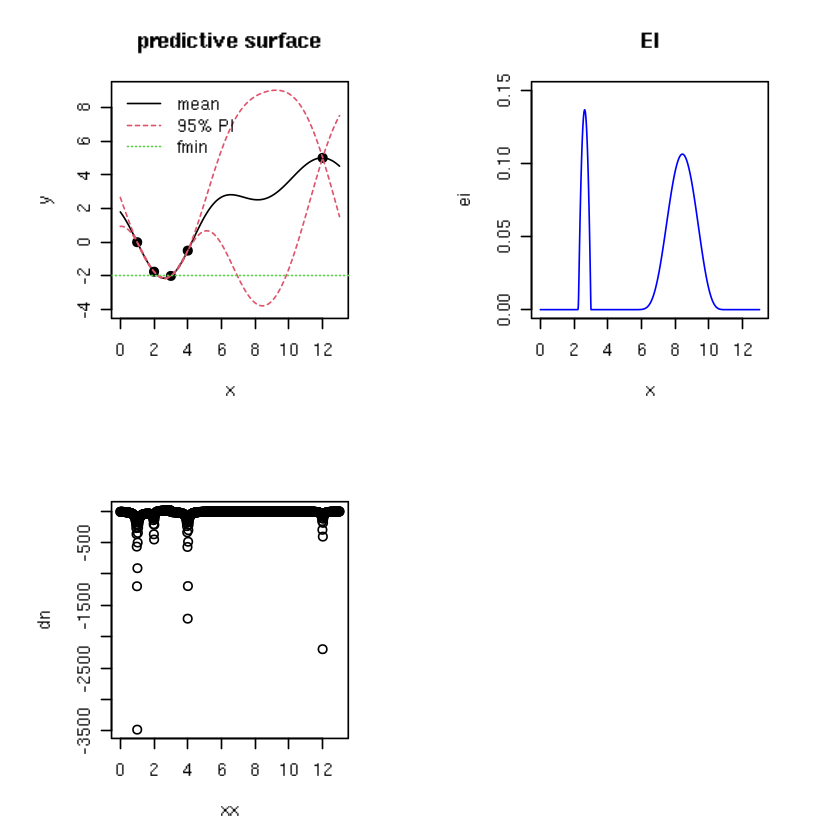

In [35]:
par(mfrow=c(2,2), pty="s")
plot(x, y, pch=19, xlim=c(0,13), ylim=c(-4,9), main="predictive surface")
lines(xx, p$mean)
lines(xx, p$mean + 2*sqrt(p$s2), col=2, lty=2)
lines(xx, p$mean - 2*sqrt(p$s2), col=2, lty=2)
abline(h=fmin, col=3, lty=3)
legend("topleft", c("mean", "95% PI", "fmin"), lty=1:3, col=1:3, bty="n")
plot(xx, ei, type="l", col="blue", main="EI", xlab="x", ylim=c(0,0.15))
plot(xx, dn)

In [36]:
mm <- which.max(ei)
x <- c(x, xx[mm])
y <- c(y, p$mean[mm])

In [37]:
updateGP(gpi, matrix(xx[mm], ncol=1), p$mean[mm])
p <- predGP(gpi, matrix(xx, ncol=1), lite=TRUE)
deleteGP(gpi)

In [38]:
m <- which.min(y)
fmin <- y[m]
d <- fmin - p$mean
s <- sqrt(p$s2)
dn <- d/s
ei <- d*pnorm(dn) + s*dnorm(dn)

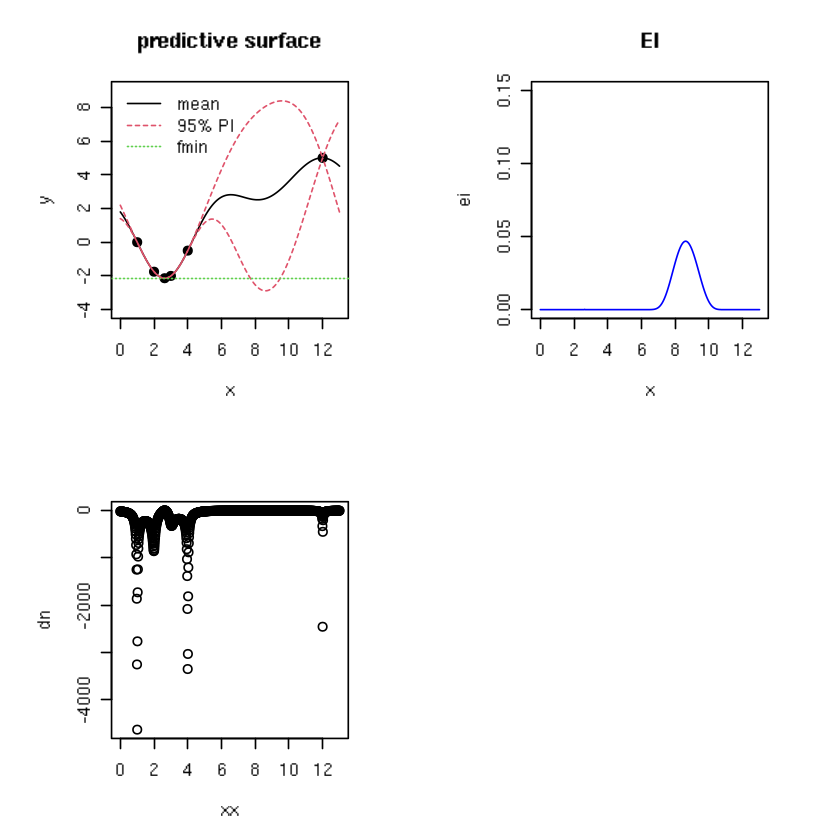

In [39]:
par(mfrow=c(2,2), pty="s")
plot(x, y, pch=19, xlim=c(0,13), ylim=c(-4,9), main="predictive surface")
lines(xx, p$mean)
lines(xx, p$mean + 2*sqrt(p$s2), col=2, lty=2)
lines(xx, p$mean - 2*sqrt(p$s2), col=2, lty=2)
abline(h=fmin, col=3, lty=3)
legend("topleft", c("mean", "95% PI", "fmin"), lty=1:3, 
  col=1:3, bty="n")
plot(xx, ei, type="l", col="blue", main="EI", xlab="x", ylim=c(0,0.15))
plot(xx, dn)

In [40]:
EI <- function(gpi, x, fmin, pred=predGPsep)
 {
  if(is.null(nrow(x))) x <- matrix(x, nrow=1)
  p <- pred(gpi, x, lite=TRUE)
  d <- fmin - p$mean
  sigma <- sqrt(p$s2)
  dn <- d/sigma
  ei <- d*pnorm(dn) + sigma*dnorm(dn)
  return(ei)
 }

### 7.2.2 EI on our running example

In [41]:
obj.EI <- function(x, fmin, gpi, pred=predGPsep) 
  - EI(gpi, x, fmin, pred)

In [42]:
eps <- sqrt(.Machine$double.eps) ## used lots below

EI.search <- function(X, y, gpi, pred=predGPsep, multi.start=5, tol=eps)
 {
  m <- which.min(y)
  fmin <- y[m]
  start <- matrix(X[m,], nrow=1)
  if(multi.start > 1) 
    start <- rbind(start, randomLHS(multi.start - 1, ncol(X)))
  xnew <- matrix(NA, nrow=nrow(start), ncol=ncol(X)+1)
  for(i in 1:nrow(start)) {
    if(EI(gpi, start[i,], fmin) <= tol) { out <- list(value=-Inf); next }
    out <- optim(start[i,], obj.EI, method="L-BFGS-B", 
      lower=0, upper=1, gpi=gpi, pred=pred, fmin=fmin)
    xnew[i,] <- c(out$par, -out$value)
  }
  solns <- data.frame(cbind(start, xnew))
  names(solns) <- c("s1", "s2", "x1", "x2", "val")
  solns <- solns[solns$val > tol,]
  return(solns)
}

In [43]:
set.seed(1)
X <- randomLHS(ninit, 2)
y <- f(X)
gpi <- newGPsep(X, y, d=0.1, g=1e-6, dK=TRUE)
da <- darg(list(mle=TRUE, max=0.5), randomLHS(1000, 2))

In [44]:
solns <- EI.search(X, y, gpi)
m <- which.max(solns$val)
maxei <- solns$val[m]

In [45]:
solns

,s1,s2,x1,x2,val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7269759,0.3676062,0.8779383,0.5295087,2.534319e-01
2,0.7872056,0.2596188,0.7872063,0.2596255,2.661721e-08
3,0.6947437,0.5045489,0.8779384,0.5295088,2.534319e-01
4,0.3070098,0.2127619,0.3627334,0.3398005,4.115030e-02
NA,NA,NA,NA,NA,NA


Warning message in arrows(solns$s1, solns$s2, solns$x1, solns$x2, length = 0.1):
“zero-length arrow is of indeterminate angle and so skipped”


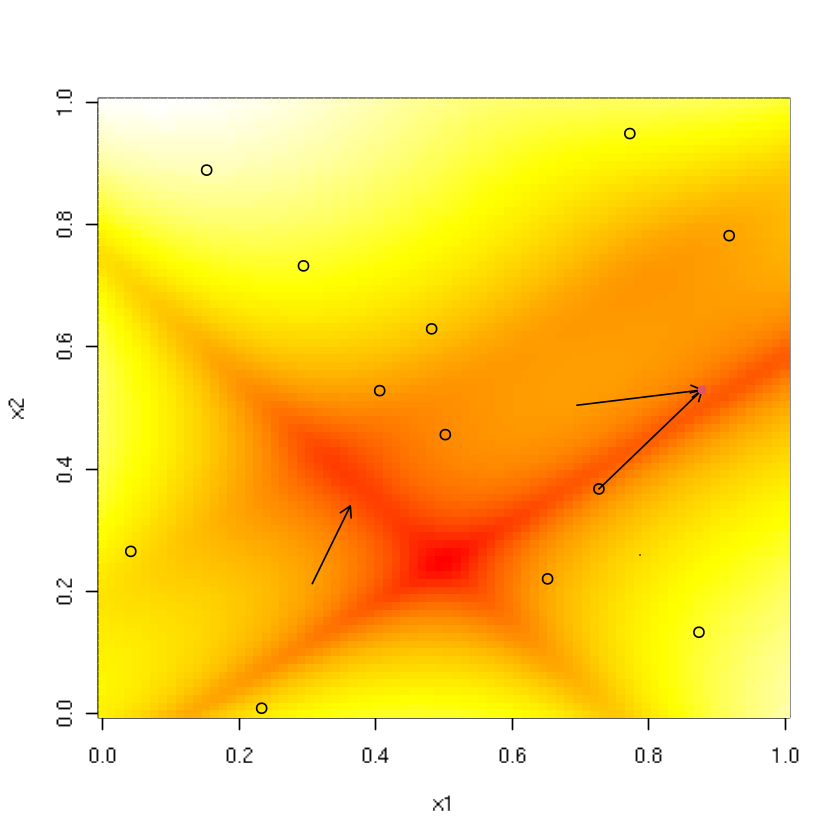

In [46]:
image(x1, x2, Y, col=heat.colors(128))
points(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
points(solns$x1[m], solns$x2[m], col=2, pch=20)

In [47]:
xnew <- as.matrix(solns[m,3:4])
X <- rbind(X, xnew)
y <- c(y, f(xnew))
updateGPsep(gpi, xnew, y[length(y)])
mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)

In [48]:
solns <- EI.search(X, y, gpi)
m <- which.max(solns$val)
maxei <- c(maxei, solns$val[m])
xnew <- as.matrix(solns[m,3:4])
X <- rbind(X, xnew)
y <- c(y, f(xnew))
updateGPsep(gpi, xnew, y[length(y)])
mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)

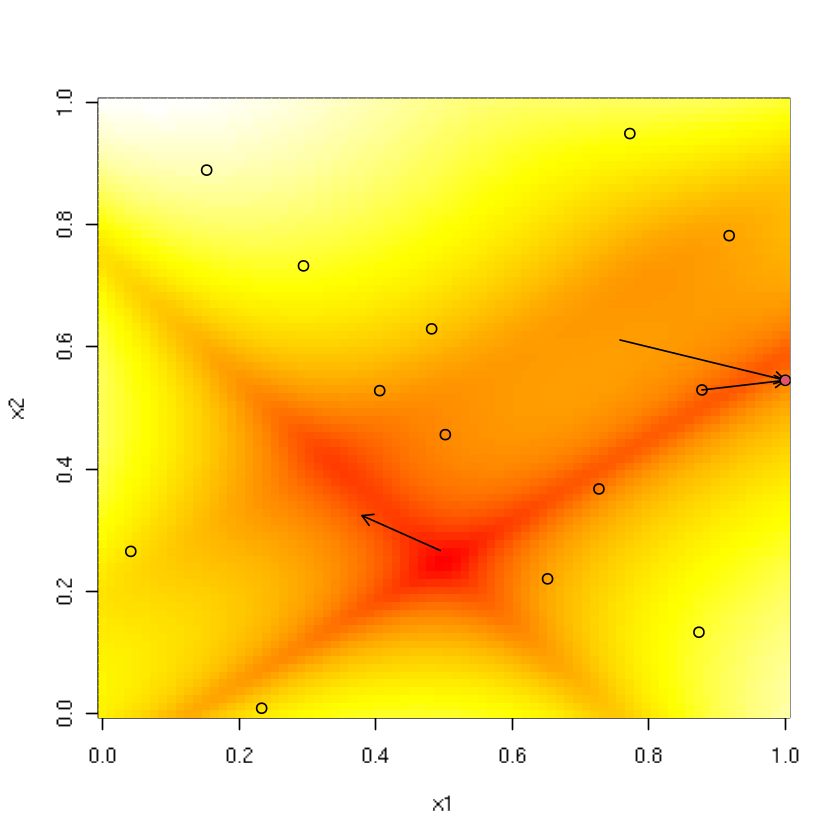

In [49]:
image(x1, x2, Y, col=heat.colors(128))
points(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
points(solns$x1[m], solns$x2[m], col=2, pch=20)

In [50]:
for(i in nrow(X):end) {
  solns <- EI.search(X, y, gpi)
  m <- which.max(solns$val)
  maxei <- c(maxei, solns$val[m])
  xnew <- as.matrix(solns[m,3:4])
  ynew <- f(xnew)
  X <- rbind(X, xnew)
  y <- c(y, ynew)
  updateGPsep(gpi, xnew, y[length(y)])
  mle <- mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
}
deleteGPsep(gpi)

In [51]:
prog.ei <- bov(y)

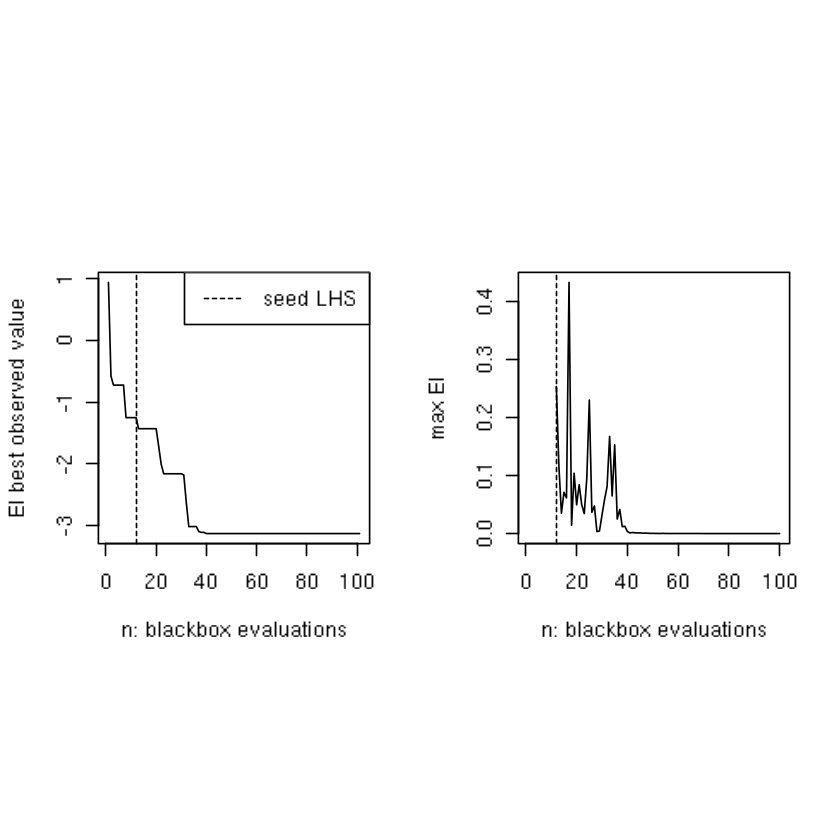

In [52]:
par(mfrow=c(1,2), pty="s")
plot(prog.ei, type="l", xlab="n: blackbox evaluations", 
  ylab="EI best observed value")
abline(v=ninit, lty=2)
legend("topright", "seed LHS", lty=2)
plot(ninit:end, maxei, type="l",  xlim=c(1,end), 
  xlab="n: blackbox evaluations", ylab="max EI")
abline(v=ninit, lty=2)

In [53]:
optim.EI <- function(f, ninit, end)
 {
  ## initialization
  X <- randomLHS(ninit, 2)
  y <- f(X)
  gpi <- newGPsep(X, y, d=0.1, g=1e-6, dK=TRUE)
  da <- darg(list(mle=TRUE, max=0.5), randomLHS(1000, 2))
  mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
    
  ## optimization loop of sequential acquisitions
  maxei <- c()
  for(i in (ninit+1):end) {
    solns <- EI.search(X, y, gpi)
    m <- which.max(solns$val)
    maxei <- c(maxei, solns$val[m])
    xnew <- as.matrix(solns[m,3:4])
    ynew <- f(xnew)
    updateGPsep(gpi, xnew, ynew)
    mleGPsep(gpi, param="d", tmin=da$min, tmax=da$max, ab=da$ab)
    X <- rbind(X, xnew)
    y <- c(y, ynew)
  }

  ## clean up and return
  deleteGPsep(gpi)
  return(list(X=X, y=y, maxei=maxei))
 }

In [54]:
reps <- 100
prog.ei <- matrix(NA, nrow=reps, ncol=end)
for(r in 1:reps) {
  os <- optim.EI(f, ninit, end)
  prog.ei[r,] <- bov(os$y)
}

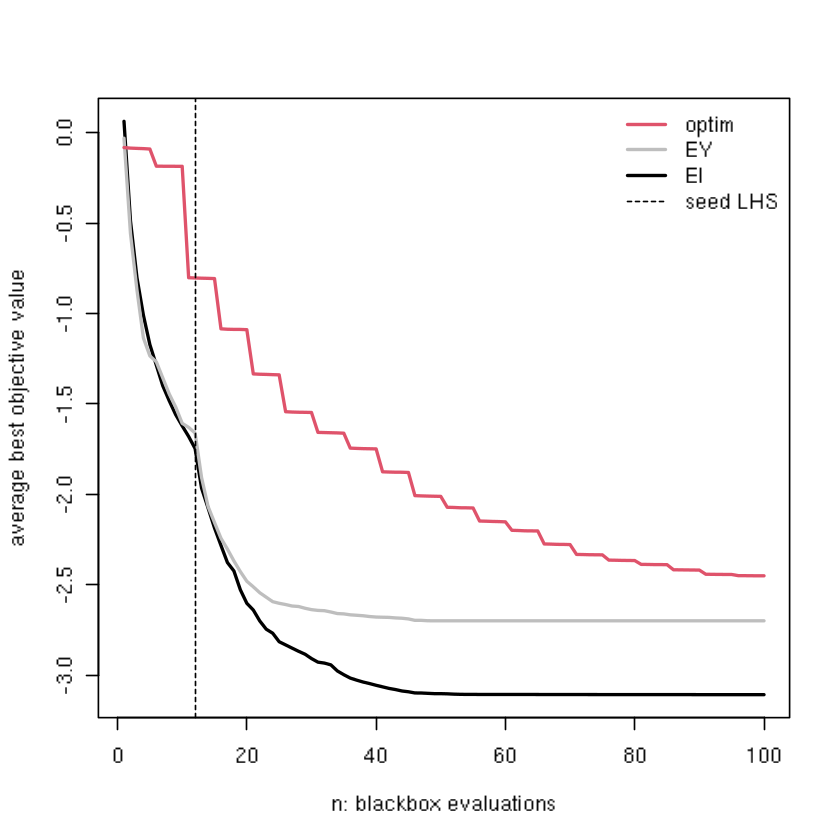

In [55]:
plot(colMeans(prog.ei), col=1, lwd=2, type="l", 
  xlab="n: blackbox evaluations", ylab="average best objective value")
lines(colMeans(prog), col="gray", lwd=2)
lines(colMeans(prog.optim, na.rm=TRUE), col=2, lwd=2)
abline(v=ninit, lty=2)
legend("topright", c("optim", "EY", "EI", "seed LHS"), 
  col=c(2, "gray", 1, 1), lwd=c(2,2,2,1), lty=c(1,1,1,2), 
  bty="n")

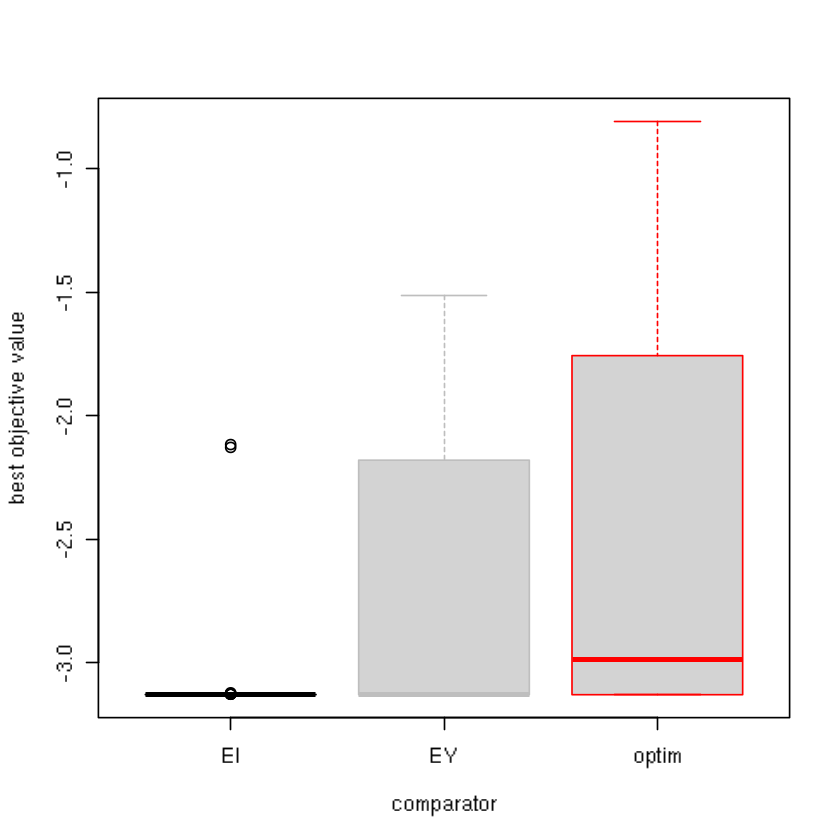

In [56]:
boxplot(prog.ei[,end], prog[,end], prog.optim[,end], 
  names=c("EI", "EY", "optim"), border=c("black", "gray", "red"), 
  xlab="comparator", ylab="best objective value")

### 7.2.5 Illustrating conditional improvement and noise

In [57]:
set.seed(22)
fsindn <- function(x) {
  sin(x) - 2.55*dnorm(x,1.6,0.45)
}

X <- matrix(c(0, 0.3, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.5, 
  2.8, 3.1, 3.4, 3.7, 4.4, 5.3, 5.7, 6.1, 6.5, 7), ncol=1)
y <- fsindn(X) + rnorm(length(X), sd=0.15)

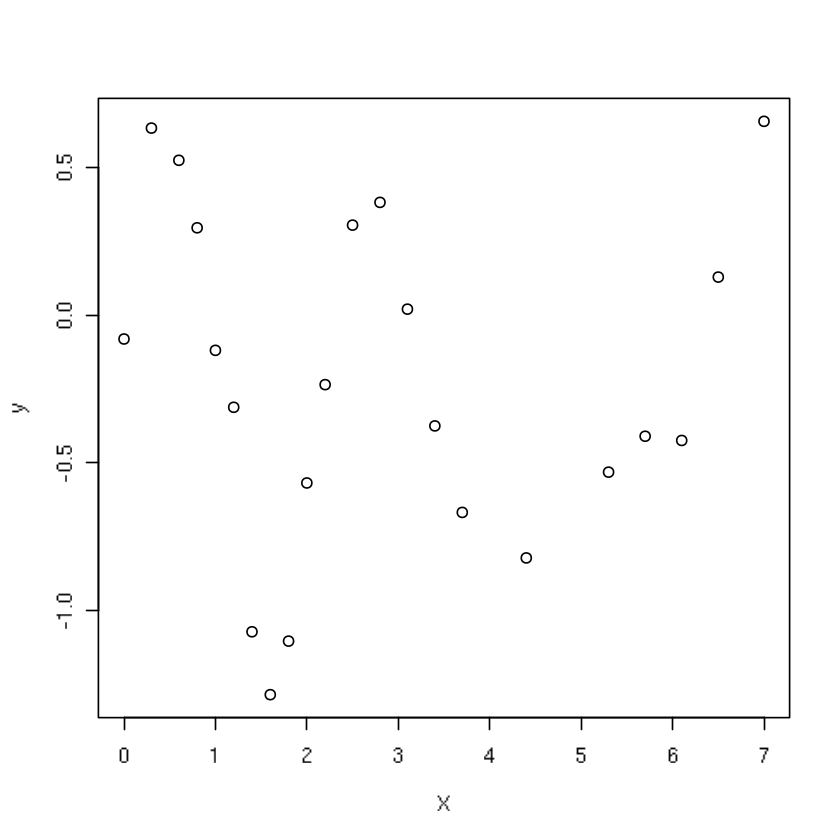

In [58]:
plot(X, y)

In [59]:
gpi <- newGP(X, y, d=0.1, g=0.1*var(y), dK=TRUE)
mle <- jmleGP(gpi)

In [60]:
XX <- matrix(seq(0, 7, length=201), ncol=1)
pY <- predGP(gpi, XX, lite=TRUE)
pf <- predGP(gpi, XX, lite=TRUE, nonug=TRUE)

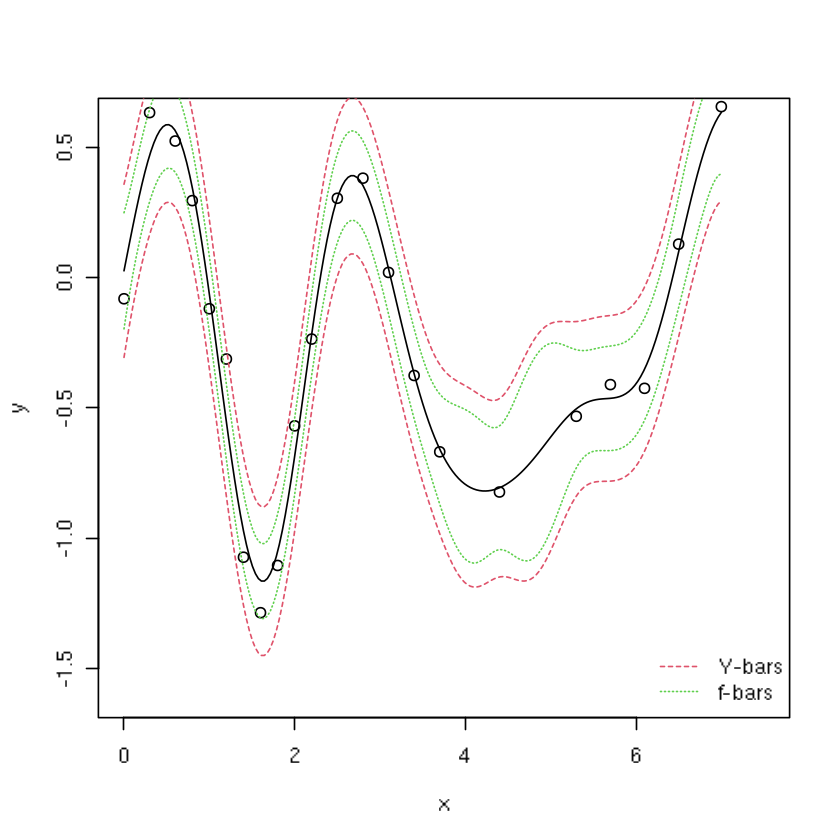

In [61]:
plot(X, y, xlab="x", ylab="y", ylim=c(-1.6,0.6), xlim=c(0,7.5))
lines(XX, pY$mean)
lines(XX, pY$mean + 1.96*sqrt(pY$s2), col=2, lty=2)
lines(XX, pY$mean - 1.96*sqrt(pY$s2), col=2, lty=2)
lines(XX, pf$mean + 1.96*sqrt(pf$s2), col=3, lty=3)
lines(XX, pf$mean - 1.96*sqrt(pf$s2), col=3, lty=3)
legend("bottomright", c("Y-bars", "f-bars"), col=2:4, lty=2:3, bty="n")

In [62]:
fmin <- min(predGP(gpi, X, lite=TRUE)$mean)
ei <- EI(gpi, XX, fmin, pred=predGP)
ieci <- ieciGP(gpi, XX, fmin)
predGPnonug <- predGP
formals(predGPnonug)$nonug <- TRUE
ei.f <- EI(gpi, XX, fmin, pred=predGPnonug)
ieci.f <- ieciGP(gpi, XX, fmin, nonug=TRUE)

In [63]:
ei <- scale(ei, min(ei), max(ei) - min(ei))
ei.f <- scale(ei.f, min(ei.f), max(ei.f) - min(ei.f))
ieci <- scale(ieci, min(ieci), max(ieci) - min(ieci))
ieci.f <- scale(ieci.f, min(ieci.f), max(ieci.f) - min(ieci.f))

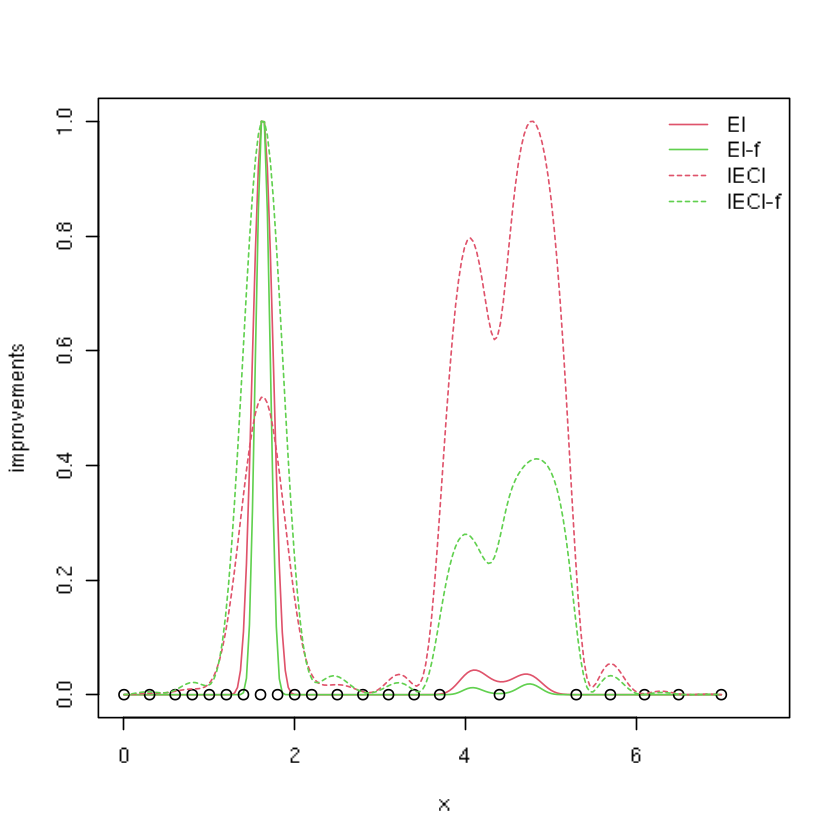

In [64]:
plot(XX, ei, type="l", ylim=c(0, 1), xlim=c(0,7.5), col=2, lty=1, 
  xlab="x", ylab="improvements")
lines(XX, ei.f, col=3, lty=1)
points(X, rep(0, nrow(X)))
lines(XX, 1-ieci, col=2, lty=2)
lines(XX, 1-ieci.f, col=3, lty=2)
legend("topright", c("EI", "EI-f", "IECI", "IECI-f"), lty=c(1,1,2,2), 
  col=c(2,3,2,3), bty="n")

## 7.3 Optimization under constraints

In [65]:
X <- matrix(c(0, 0.3, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 4.4, 5.3, 5.7, 
  6.1, 6.5, 7), ncol=1)
y <- fsindn(X) + rnorm(length(X), sd=0.15)

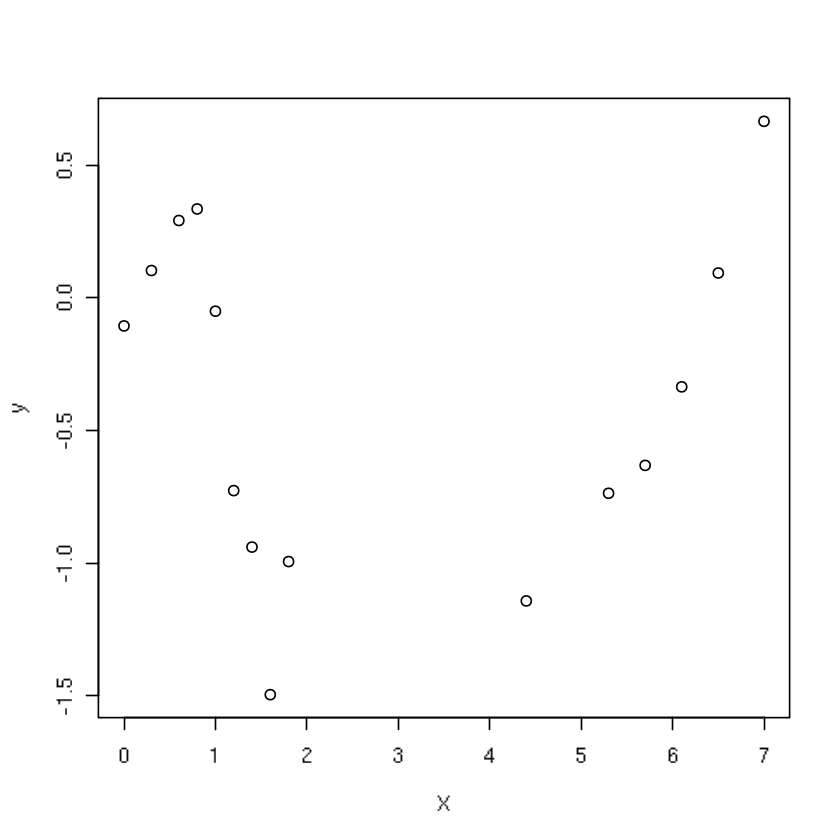

In [66]:
plot(X, y)

In [67]:
gpi <- newGP(X, y, d=5, g=0.1*var(y), dK=TRUE)
XX <- matrix(seq(0, 7, length=201), ncol=1)
p <- predGP(gpi, XX, lite=TRUE)

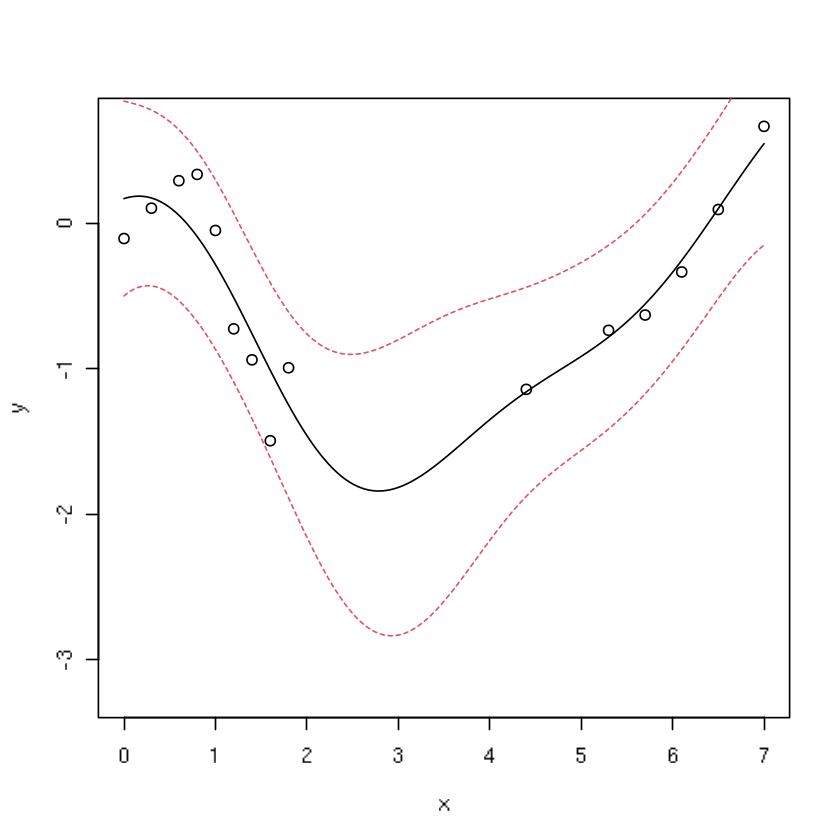

In [68]:
plot(X, y, xlab="x", ylab="y", ylim=c(-3.24, 0.7))
lines(XX, p$mean)
lines(XX, p$mean + 1.96*sqrt(p$s2), col=2, lty=2)
lines(XX, p$mean - 1.96*sqrt(p$s2), col=2, lty=2)

In [69]:
fmin <- min(predGP(gpi, X, lite=TRUE)$mean)
ei <- EI(gpi, XX, fmin, pred=predGPnonug)
ei <- scale(ei, min(ei), max(ei) - min(ei))

In [70]:
range(ei)

[1] 0 1

In [71]:
lc <- 2
rc <- 4
eiref <- c(ei[XX <lc], ei[XX > rc])

In [72]:
Xref <- matrix(c(XX[XX < lc,], XX[XX > rc,]), ncol=1)

In [73]:
ieci <- ieciGP(gpi, XX, fmin, Xref=Xref, nonug=TRUE)
ieci <- scale(ieci, min(ieci), max(ieci) - min(ieci))

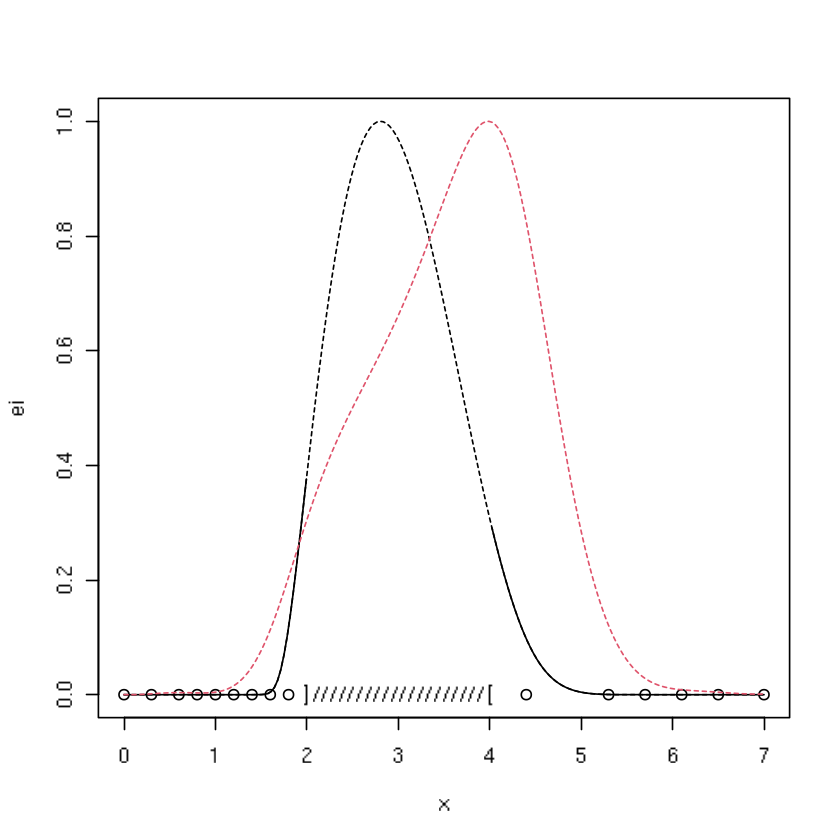

In [74]:
plot(XX, ei, type="l", ylim=c(0, max(ei)), lty=2, xlab="x")
lines(Xref[Xref < lc], eiref[Xref < lc])
lines(Xref[Xref > rc], eiref[Xref > rc])
points(X, rep(0, nrow(X)))
lines(XX, 1 - ieci, col=2, lty=2)
text(lc, 0, "]")
text(rc, 0, "[")
text(seq(lc+.1, rc-.1, length=20), rep(0, 20), rep("/", 20))

### 7.3.2 Blackbox binary constraints

In [75]:
set.seed(45)
X <- matrix(c(1, 3, 4, 5, 6, 7))
y <- fsindn(X) + rnorm(length(X), sd=0.15)
const <- as.numeric(X > lc & X < rc)

In [76]:
const

[1] 0 1 0 0 0 0

In [77]:
gpi <- newGP(X, y, d=1, g=0.1*var(y), dK=TRUE)
ga <- garg(list(mle=TRUE, max=var(y)), y)
mle <- mleGP(gpi, param="g", tmin=eps, tmax=var(y), ab=ga$ab)

In [78]:
library(randomForest)
cfit <- randomForest(X, as.factor(const))
cfit

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.




Call:
 randomForest(x = X, y = as.factor(const)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 40%
Confusion matrix:
  0 1 class.error
0 3 2         0.4
1 0 0         NaN

In [79]:
Xv <- X[const <= 0,,drop=FALSE]
fmin <- min(predGP(gpi, Xv, lite=TRUE)$mean)

In [80]:
pc <- predict(cfit, XX, type="prob")[,1]
ei <- EI(gpi, XX, fmin, pred=predGPnonug)
ei <- scale(ei, min(ei), max(ei) - min(ei))

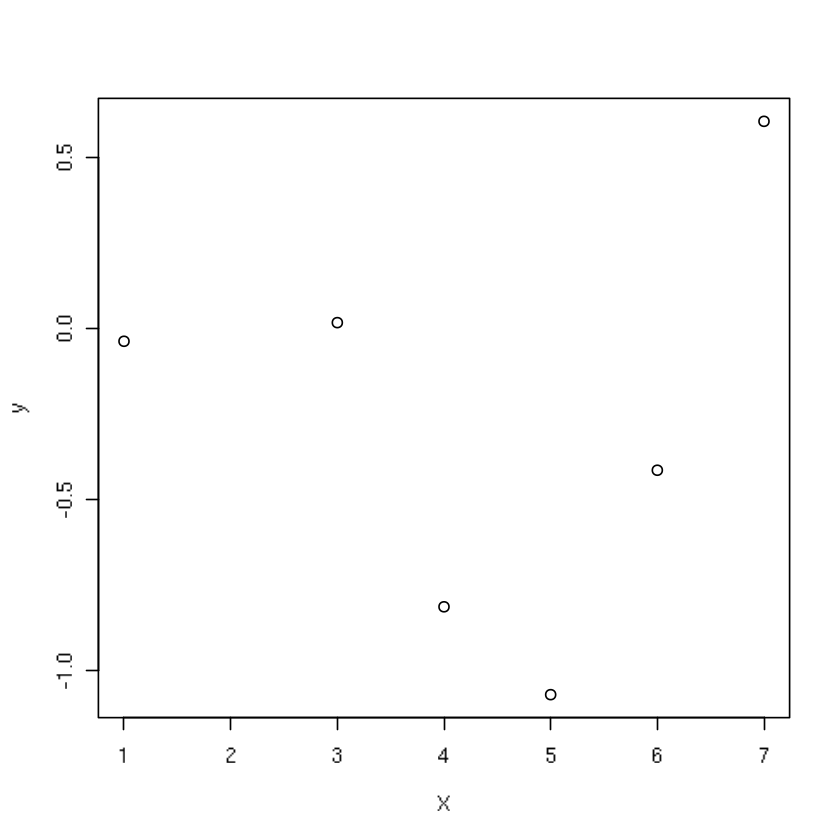

In [81]:
plot(X, y)

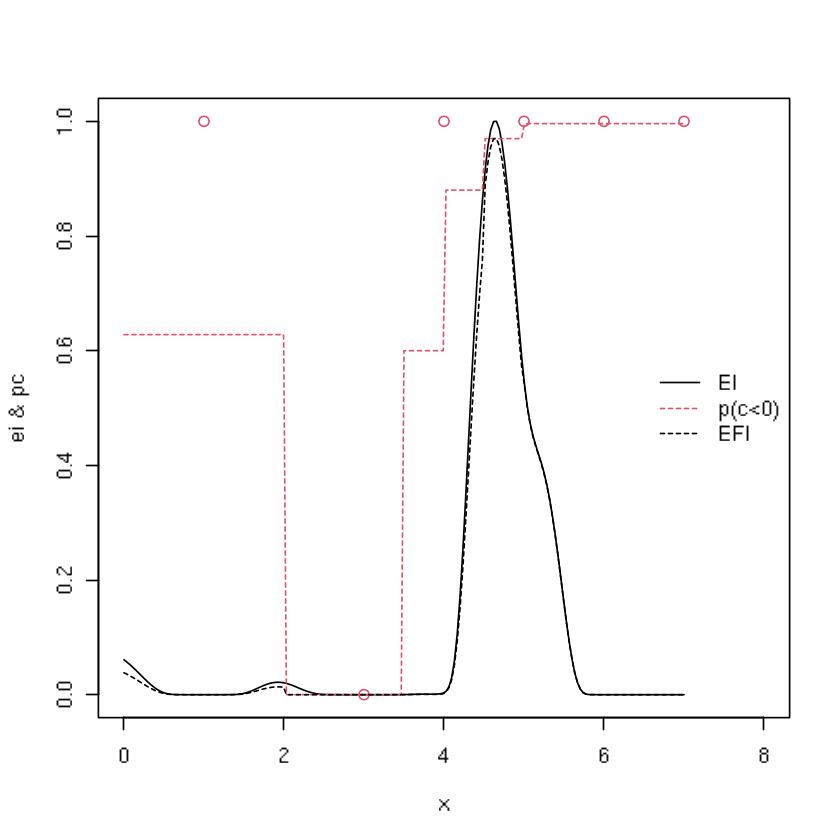

In [82]:
plot(XX, ei, type="l", xlim=c(0,8), ylim=c(0,1), xlab="x", ylab="ei & pc")
lines(XX, pc, col=2, lty=2)
points(X, 1 - const, col=2)
lines(XX, ei*pc, lty=2)
legend("right", c("EI", "p(c<0)", "EFI"), col=c(1,2,1), 
  lty=c(1,2,2), bty="n")

In [83]:
m <- which.max(ei*pc)
X <- rbind(X, XX[m,])
y <- c(y, fsindn(XX[m,]) + rnorm(1, sd=0.15))
const <- c(const, as.numeric(XX[m,] > lc && XX[m,] < rc))

In [84]:
updateGP(gpi, X[nrow(X),,drop=FALSE], y[length(y)])
mle <- mleGP(gpi, param="g", tmin=eps, tmax=var(y), ab=ga$ab)
cfit <- randomForest(X, as.factor(const))

In [85]:
Xv <- X[const <= 0,,drop=FALSE]
fmin <- min(predGP(gpi, Xv, lite=TRUE)$mean)
pc <- predict(cfit, XX, type="prob")[,1]
ei <- EI(gpi, XX, fmin, pred=predGPnonug)
ei <- scale(ei, min(ei), max(ei) - min(ei))

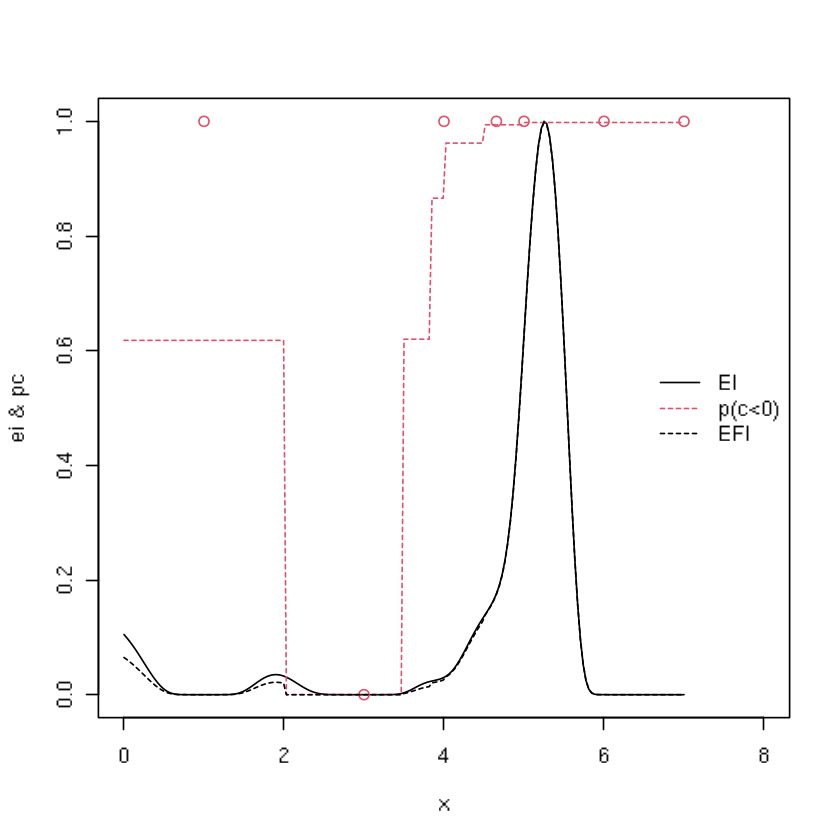

In [86]:
plot(XX, ei, type="l", xlim=c(0,8), ylim=c(0,1), xlab="x", ylab="ei & pc")
lines(XX, pc, col=2, lty=2)
points(X, 1 - const, col=2)
lines(XX, ei*pc, lty=2)
legend("right", c("EI", "p(c<0)", "EFI"), col=c(1,2,1), 
  lty=c(1,2,2), bty="n")

In [87]:
for(i in 1:10) {
  m <- which.max(ei*pc)
  X <- rbind(X, XX[m,])
  y <- c(y, fsindn(XX[m,]) + rnorm(1, sd=0.15))
  const <- c(const, as.numeric(XX[m,] > lc && XX[m,] < rc))
  updateGP(gpi, X[nrow(X),,drop=FALSE], y[length(y)])
  mle <- jmleGP(gpi, drange=c(eps, 2), grange=c(eps, var(y)), gab=ga$ab)
  cfit <- randomForest(X, as.factor(const))
  Xv <- X[const <= 0,,drop=FALSE]
  fmin <- min(predGP(gpi, Xv, lite=TRUE)$mean)
  pc <- predict(cfit, XX, type="prob")[,1]
  ei <- EI(gpi, XX, fmin, pred=predGPnonug)
  ei <- scale(ei, min(ei), max(ei) - min(ei))
}

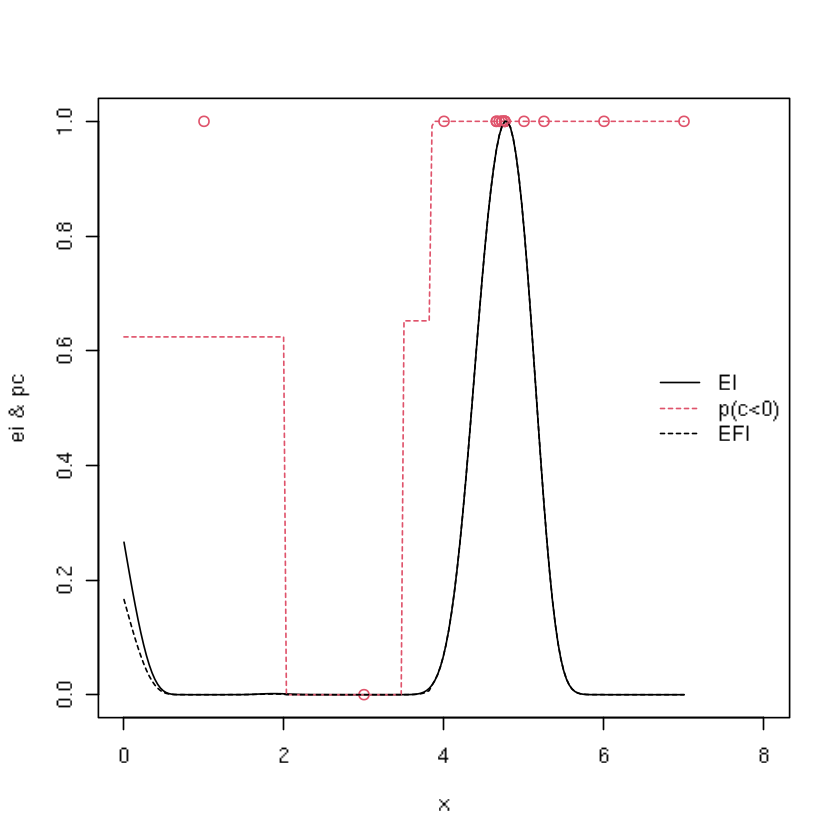

In [88]:
plot(XX, ei, type="l", xlim=c(0,8), ylim=c(0,1), xlab="x", ylab="ei & pc")
lines(XX, pc, col=2, lty=2)
points(X, 1 - const, col=2)
lines(XX, ei*pc, lty=2)
legend("right", c("EI", "p(c<0)", "EFI"), col=c(1,2,1), 
  lty=c(1,2,2), bty="n")

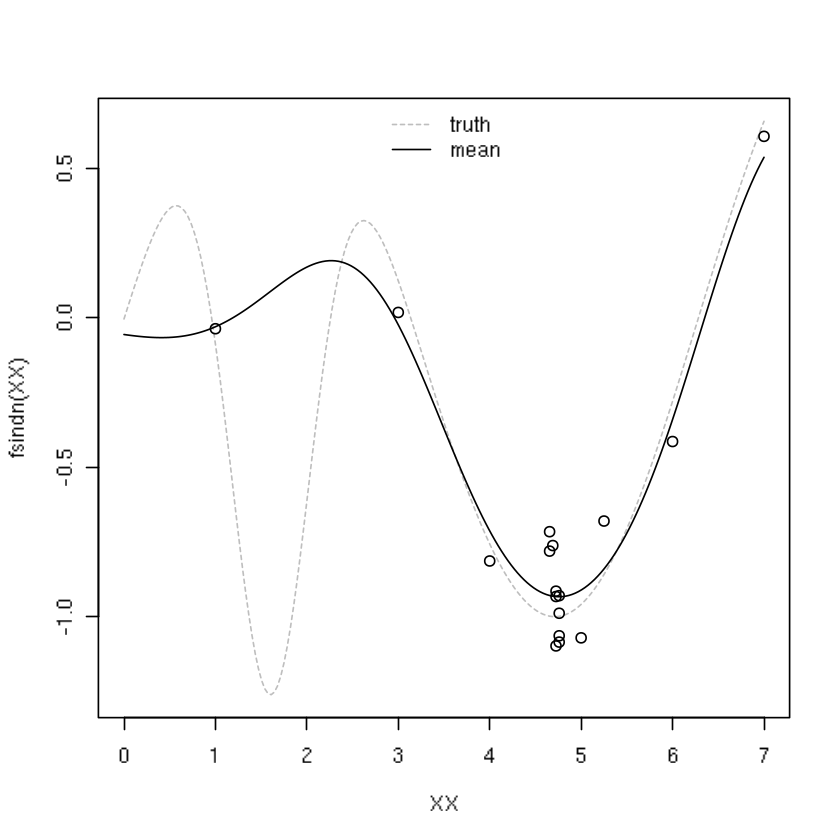

In [89]:
p <- predGP(gpi, XX, lite=TRUE)
plot(XX, fsindn(XX), col="gray", type="l", lty=2)
points(X, y)
lines(XX, p$mean)
legend("top", c("truth", "mean"), col=c("gray", 1), lty=c(2,1), bty="n")

In [90]:
deleteGP(gpi)
X <- X[1:ninit,,drop=FALSE]
y <- y[1:ninit]
const <- const[1:ninit]
gpi <- newGP(X, y, d=1, g=0.1*var(y), dK=TRUE)
mle <- mleGP(gpi, param="g", tmin=eps, tmax=var(y), ab=ga$ab)
cfit <- randomForest(X, as.factor(const))
pc <- predict(cfit, XX, type="prob")[,1]

In [91]:
Xv <- X[const <= 0,,drop=FALSE]
fmin <- min(predGP(gpi, Xv, lite=TRUE)$mean)
ieci <- ieciGP(gpi, XX, fmin, w=pc, nonug=TRUE)
ieci <- scale(ieci, min(ieci), max(ieci) - min(ieci))

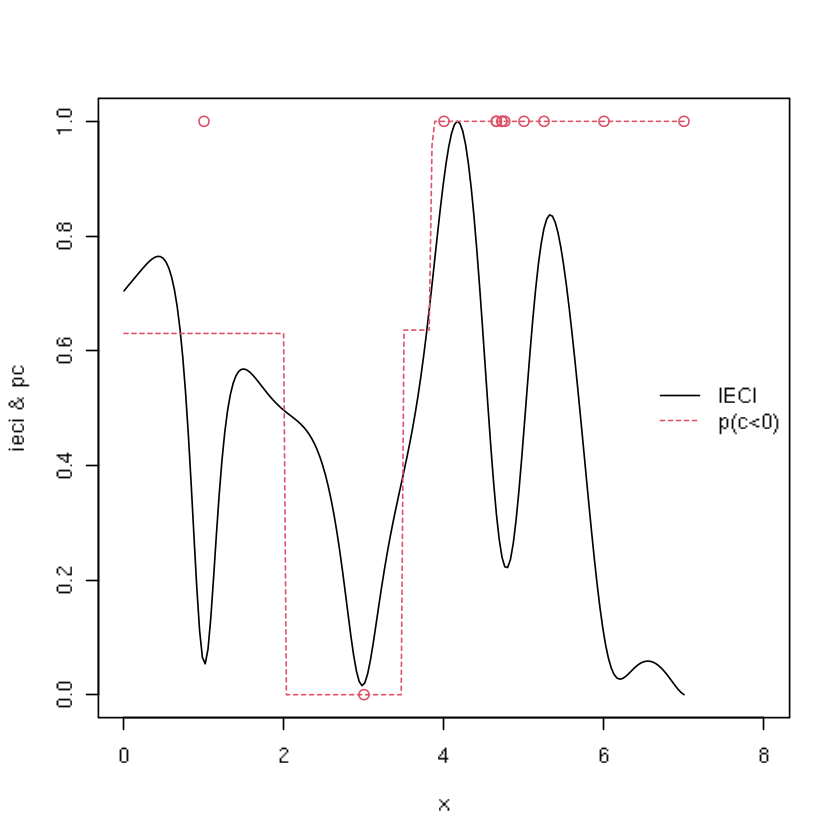

In [92]:
plot(XX, 1 - ieci, type="l", xlim=c(0,8), ylim=c(0,1), 
  xlab="x", ylab="ieci & pc")
lines(XX, pc, col=2, lty=2)
points(X, 1 - const, col=2)
legend("right", c("IECI", "p(c<0)"), col=c(1,2,2), lty=c(1,2,1), bty="n")

In [93]:
m <- which.min(ieci)
X <- rbind(X, XX[m,])
y <- c(y, fsindn(XX[m,]) + rnorm(1, sd=0.15))
const <- c(const, as.numeric(XX[m,] > lc && XX[m,] < rc))

In [94]:
updateGP(gpi, X[ncol(X),,drop=FALSE], y[length(y)])
mle <- mleGP(gpi, param="g", tmin=eps, tmax=var(y), ab=ga$ab)
cfit <- randomForest(X, as.factor(const))

In [95]:
Xv <- X[const <= 0,,drop=FALSE]
fmin <- min(predGP(gpi, Xv, lite=TRUE)$mean)
pc <- predict(cfit, XX, type="prob")[,1]
ieci <- ieciGP(gpi, XX, fmin, w=pc, nonug=TRUE)
ieci <- scale(ieci, min(ieci), max(ieci) - min(ieci))

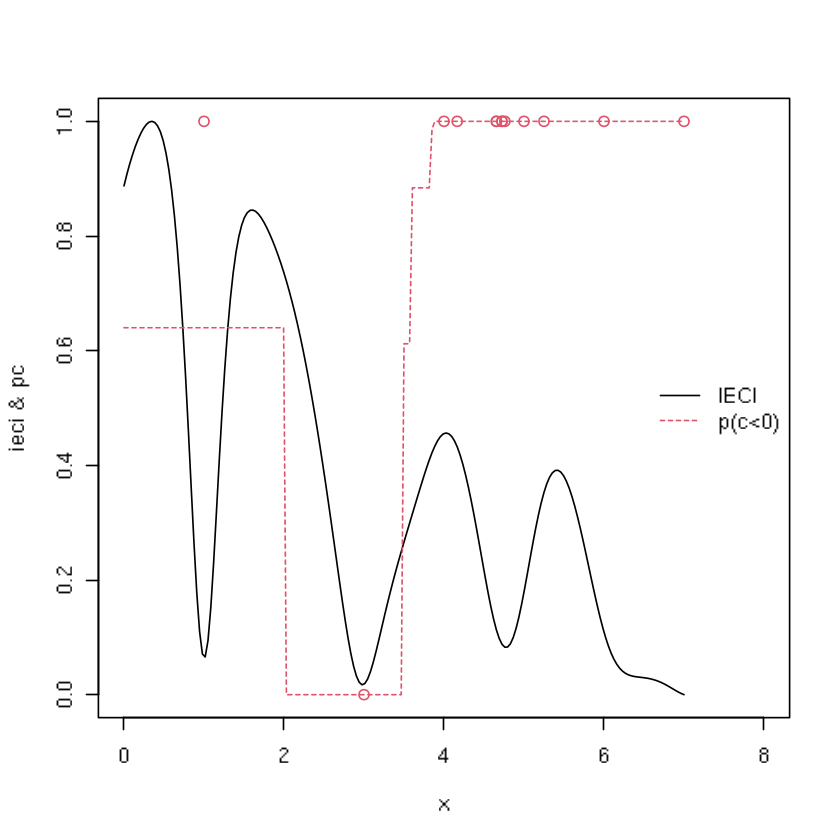

In [96]:
plot(XX, 1 - ieci, type="l", xlim=c(0,8), ylim=c(0,1), 
  xlab="x", ylab="ieci & pc")
lines(XX, pc, col=2, lty=2)
points(X, 1 - const, col=2)
legend("right", c("IECI", "p(c<0)"), col=c(1,2,2), lty=c(1,2,1), bty="n")

In [97]:
for(i in 1:30) {
  m <- which.min(ieci)
  X <- rbind(X, XX[m,])
  y <- c(y, fsindn(XX[m,]) + rnorm(1, sd=0.15))
  const <- c(const, as.numeric(XX[m,] > lc && XX[m,] < rc))
  updateGP(gpi, X[nrow(X),,drop=FALSE], y[length(y)])
  mle <- jmleGP(gpi, drange=c(eps, 2), grange=c(eps, var(y)), gab=ga$ab)
  cfit <- randomForest(X, as.factor(const))
  Xv <- X[const <= 0,,drop=FALSE]
  fmin <- min(predGP(gpi, Xv, lite=TRUE)$mean)
  pc <- predict(cfit, XX, type="prob")[,1]
  ieci <- ieciGP(gpi, XX, fmin, w=pc, nonug=TRUE)
  ieci <- scale(ieci, min(ieci), max(ieci) - min(ieci))
}

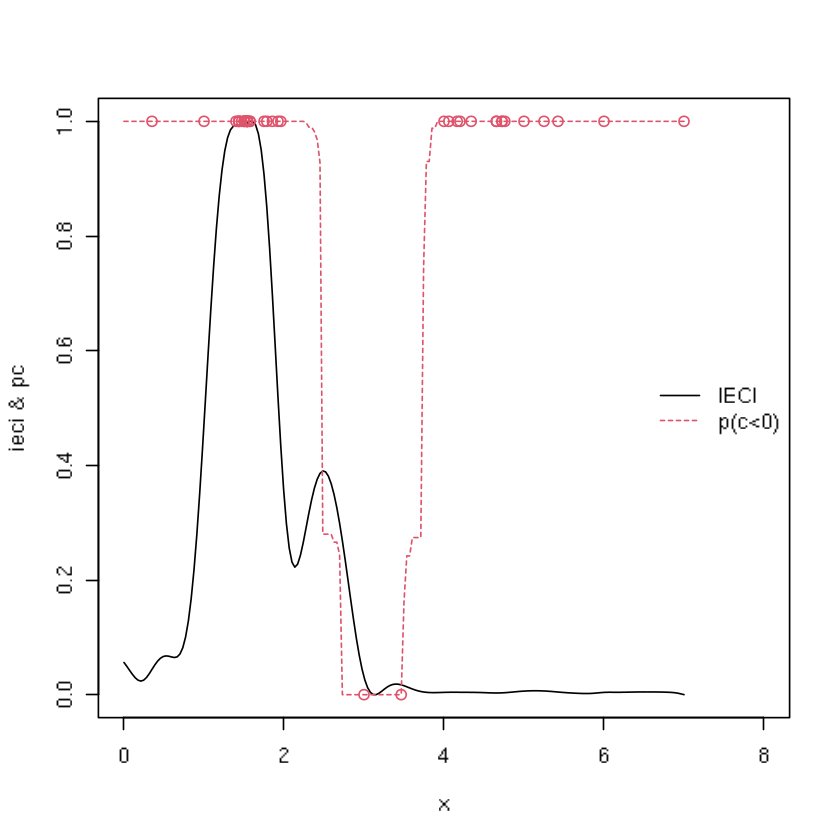

In [98]:
plot(XX, 1 - ieci, type="l", xlim=c(0,8), ylim=c(0,1), 
  xlab="x", ylab="ieci & pc")
lines(XX, pc, col=2, lty=2)
points(X, 1 - const, col=2)
legend("right", c("IECI", "p(c<0)"), col=c(1,2,2), lty=c(1,2,1), bty="n")

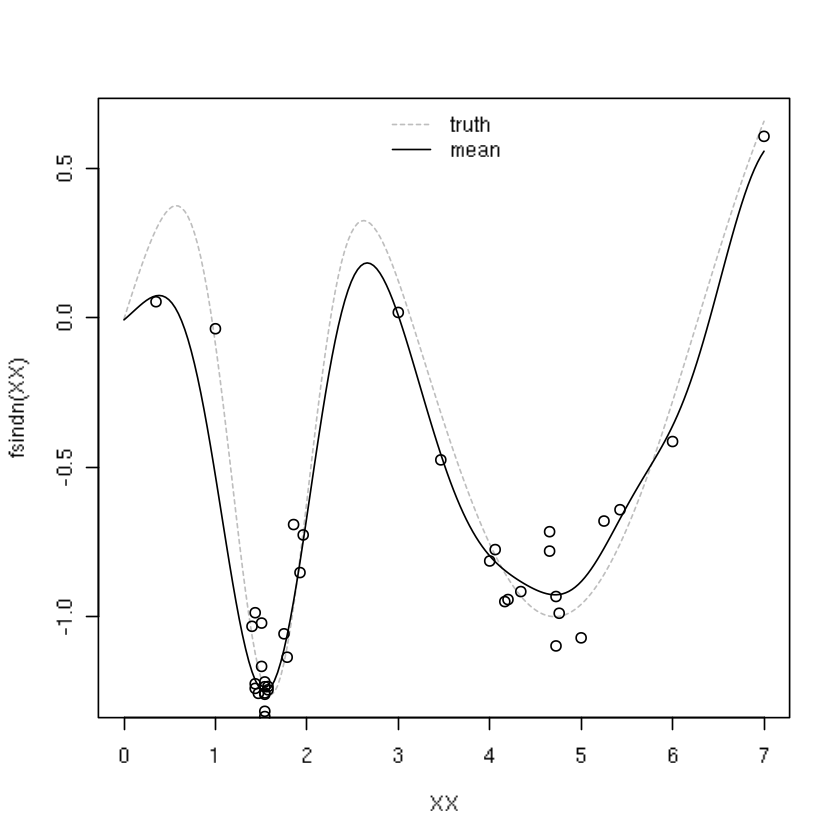

In [99]:
p <- predGP(gpi, XX, lite=TRUE)
plot(XX, fsindn(XX), col="gray", type="l", lty=2)
points(X, y)
lines(XX, p$mean)
legend("top", c("truth", "mean"), col=c("gray", 1), lty=c(2,1), bty="n")

In [100]:
deleteGP(gpi)

### 7.3.3 Real-valued constraints